# SPY Volatility Forecasting Analysis (2018-2024)

This notebook demonstrates comprehensive volatility forecasting on SPY using multiple models and evaluation techniques.

## Contents
1. Data Loading and Preprocessing
2. Realized Volatility Calculation
3. GARCH Model Fitting and Forecasting
4. Walk-Forward Evaluation
5. Model Comparison and Statistical Tests
6. Visualization and Results

In [32]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Import our modules
import sys
sys.path.append('../src')

from data.data_loader import DataLoader
from models.garch_model import GARCHModel, EGARCHModel
from models.realized_volatility import RealizedVolatility
from evaluation.forecast_evaluation import VolatilityForecastEvaluator
from utils.visualization import VolatilityVisualizer

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Data Loading and Preprocessing

Load SPY data from 2018 to 2024 and prepare for analysis.

In [19]:
# Load SPY data
import yfinance as yf
import numpy as np
import pandas as pd

ticker = 'SPY'
start_date = '2018-01-01'
end_date = '2024-12-31'

print(f"Loading {ticker} data from {start_date} to {end_date}...")

# Download data
spy_data = yf.download(ticker, start=start_date, end=end_date, progress=False)

# Check the structure of the downloaded data
print("\nColumns in downloaded data:")
print(spy_data.columns.tolist())
print(f"Column levels: {spy_data.columns.nlevels}")

# Handle both single-level and multi-level columns
if spy_data.columns.nlevels > 1:
    # Multi-level columns - flatten them
    spy_data.columns = spy_data.columns.get_level_values(0)
    print("\nFlattened columns:", spy_data.columns.tolist())

# Alternative: Check if 'Adj Close' exists with different case
if 'Adj Close' in spy_data.columns:
    adj_close_col = 'Adj Close'
elif 'Adj_Close' in spy_data.columns:
    adj_close_col = 'Adj_Close'
elif 'Close' in spy_data.columns:
    # If only Close is available, use it
    adj_close_col = 'Close'
    print("\nNote: Using 'Close' instead of 'Adj Close'")
else:
    print("\nAvailable columns:", spy_data.columns.tolist())
    raise KeyError("Cannot find adjusted close price column")

# Calculate returns
spy_data['Returns'] = spy_data[adj_close_col].pct_change()
spy_data['Log_Returns'] = np.log(spy_data[adj_close_col] / spy_data[adj_close_col].shift(1))

# Remove first NaN value
spy_data = spy_data.dropna()

print(f"\nData loaded: {len(spy_data)} observations")
print(f"Date range: {spy_data.index[0].date()} to {spy_data.index[-1].date()}")
print(f"\nSummary Statistics:")
print(spy_data[['Returns', 'Log_Returns']].describe())

# Display first few rows
print("\nFirst 5 rows:")
print(spy_data[['Open', 'High', 'Low', 'Close', 'Volume', 'Returns', 'Log_Returns']].head())

Loading SPY data from 2018-01-01 to 2024-12-31...

Columns in downloaded data:
[('Close', 'SPY'), ('High', 'SPY'), ('Low', 'SPY'), ('Open', 'SPY'), ('Volume', 'SPY')]
Column levels: 2

Flattened columns: ['Close', 'High', 'Low', 'Open', 'Volume']

Note: Using 'Close' instead of 'Adj Close'

Data loaded: 1759 observations
Date range: 2018-01-03 to 2024-12-30

Summary Statistics:
Price      Returns  Log_Returns
count  1759.000000  1759.000000
mean      0.000585     0.000510
std       0.012262     0.012309
min      -0.109424    -0.115887
25%      -0.004406    -0.004416
50%       0.000787     0.000787
75%       0.006692     0.006670
max       0.090603     0.086731

First 5 rows:
Price             Open        High         Low       Close    Volume  \
Date                                                                   
2018-01-03  238.737381  240.228622  238.737381  240.077713  90070400   
2018-01-04  240.725771  241.577890  240.139930  241.089676  80636400   
2018-01-05  241.888465  242.

Available columns in spy_data:
['Close', 'High', 'Low', 'Open', 'Volume', 'Returns', 'Log_Returns']

DataFrame info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1759 entries, 2018-01-03 to 2024-12-30
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Close        1759 non-null   float64
 1   High         1759 non-null   float64
 2   Low          1759 non-null   float64
 3   Open         1759 non-null   float64
 4   Volume       1759 non-null   int64  
 5   Returns      1759 non-null   float64
 6   Log_Returns  1759 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 109.9 KB
None

Using column: 'Close' for price data


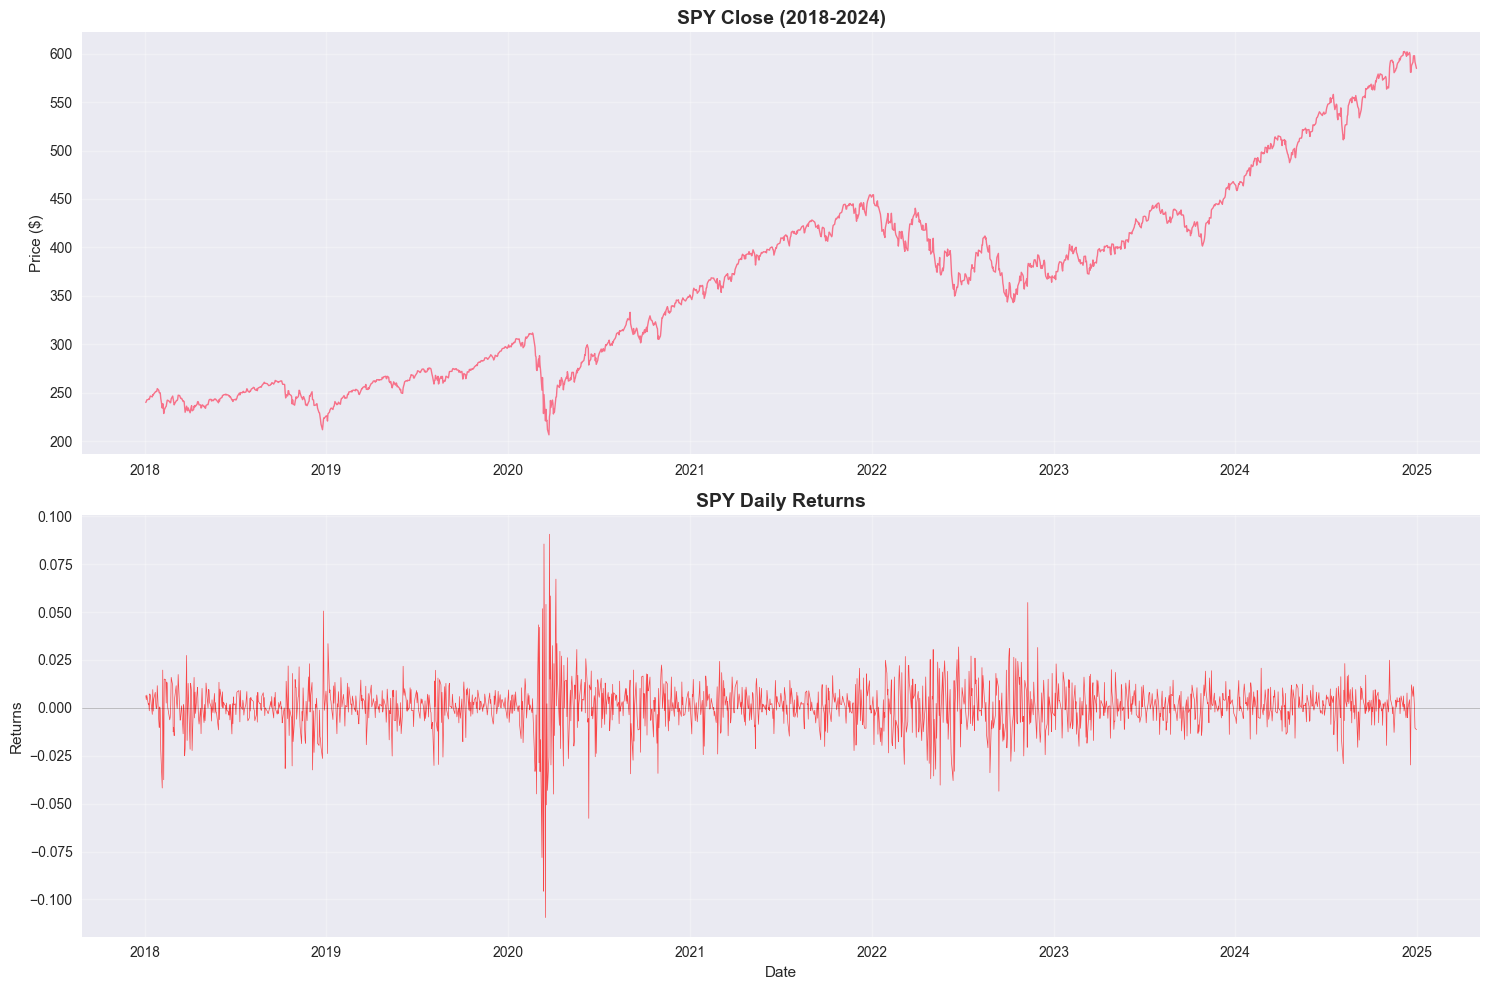


Return Statistics:
Mean daily return: 0.000510 (0.1284 annualized)
Daily volatility: 0.012309 (0.1954 annualized)
Skewness: -0.8034
Kurtosis: 12.5348
Minimum return: -0.1159
Maximum return: 0.0867
Sharpe Ratio (assuming 0 risk-free rate): 0.6573


In [21]:
# First, let's check what columns we actually have
print("Available columns in spy_data:")
print(spy_data.columns.tolist())
print("\nDataFrame info:")
print(spy_data.info())

# Determine the correct column name for adjusted close
# Check for various possible column names
possible_columns = ['Adj Close', 'Adj_Close', 'Close', 'close', 'adj_close']
price_column = None

for col in possible_columns:
    if col in spy_data.columns:
        price_column = col
        break

if price_column is None:
    # If none of the expected columns exist, use the first column that looks like a price
    # Usually price columns have numeric data
    for col in spy_data.columns:
        if spy_data[col].dtype in ['float64', 'float32', 'int64', 'int32']:
            if 'close' in col.lower() or 'price' in col.lower():
                price_column = col
                break
    
    # If still no match, just list available columns for manual selection
    if price_column is None:
        print("\nNo suitable price column found. Available columns:")
        for i, col in enumerate(spy_data.columns):
            print(f"{i}: {col} (dtype: {spy_data[col].dtype})")
        print("\nPlease check your data loading code.")
else:
    print(f"\nUsing column: '{price_column}' for price data")

# Now plot with the correct column name
import matplotlib.pyplot as plt
import numpy as np

if price_column and 'Returns' in spy_data.columns:
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))
    
    # Price chart
    axes[0].plot(spy_data.index, spy_data[price_column], linewidth=1)
    axes[0].set_title(f'SPY {price_column} (2018-2024)', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Price ($)')
    axes[0].grid(True, alpha=0.3)
    
    # Returns chart
    axes[1].plot(spy_data.index, spy_data['Returns'], linewidth=0.5, color='red', alpha=0.7)
    axes[1].set_title('SPY Daily Returns', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Returns')
    axes[1].set_xlabel('Date')
    axes[1].grid(True, alpha=0.3)
    axes[1].axhline(y=0, color='black', linestyle='-', alpha=0.3, linewidth=0.5)
    
    plt.tight_layout()
    plt.show()
    
    # Return statistics
    if 'Log_Returns' in spy_data.columns:
        returns = spy_data['Log_Returns']
        print(f"\nReturn Statistics:")
        print(f"Mean daily return: {returns.mean():.6f} ({returns.mean()*252:.4f} annualized)")
        print(f"Daily volatility: {returns.std():.6f} ({returns.std()*np.sqrt(252):.4f} annualized)")
        print(f"Skewness: {returns.skew():.4f}")
        print(f"Kurtosis: {returns.kurtosis():.4f}")
        print(f"Minimum return: {returns.min():.4f}")
        print(f"Maximum return: {returns.max():.4f}")
        print(f"Sharpe Ratio (assuming 0 risk-free rate): {(returns.mean()/returns.std())*np.sqrt(252):.4f}")
    else:
        print("\nLog_Returns column not found in DataFrame")
else:
    print("\nCannot create plots - required columns not found")
    print("Please ensure your data loading code creates 'Returns' and 'Log_Returns' columns")

## 2. Realized Volatility Calculation

Calculate various realized volatility measures using high-low-open-close data.

In [22]:
# Initialize realized volatility calculator
rv_calc = RealizedVolatility(annualization_factor=252)

# Calculate different realized volatility measures
window = 20  # 20-day rolling window

print("Calculating realized volatility measures...")

# Simple realized volatility (close-to-close)
spy_data['RV_Simple'] = rv_calc.simple_realized_vol(spy_data['Log_Returns'], window=window)

# EWMA volatility
spy_data['RV_EWMA'] = rv_calc.exponentially_weighted_vol(spy_data['Log_Returns'], alpha=0.94)

# High-frequency estimators using OHLC data
spy_data['RV_Parkinson'] = rv_calc.parkinson_vol(
    spy_data['High'], spy_data['Low'], window=window
)

spy_data['RV_GarmanKlass'] = rv_calc.garman_klass_vol(
    spy_data['Open'], spy_data['High'], spy_data['Low'], spy_data['Close'], window=window
)

spy_data['RV_RogersSatchell'] = rv_calc.rogers_satchell_vol(
    spy_data['Open'], spy_data['High'], spy_data['Low'], spy_data['Close'], window=window
)

spy_data['RV_YangZhang'] = rv_calc.yang_zhang_vol(
    spy_data['Open'], spy_data['High'], spy_data['Low'], spy_data['Close'], window=window
)

print("Realized volatility measures calculated!")

# Display summary
rv_cols = ['RV_Simple', 'RV_EWMA', 'RV_Parkinson', 'RV_GarmanKlass', 'RV_RogersSatchell', 'RV_YangZhang']
print("\nRealized Volatility Summary:")
print(spy_data[rv_cols].describe())

Calculating realized volatility measures...
Realized volatility measures calculated!

Realized Volatility Summary:
Price    RV_Simple      RV_EWMA  RV_Parkinson  RV_GarmanKlass  \
count  1740.000000  1758.000000   1740.000000     1740.000000   
mean      0.164413     0.168103      0.130599        0.131249   
std       0.108163     0.100425      0.070876        0.074038   
min       0.047514     0.017068      0.048464        0.051506   
25%       0.100111     0.108882      0.082276        0.083338   
50%       0.139142     0.141170      0.112949        0.112511   
75%       0.200856     0.201194      0.161947        0.160292   
max       0.939241     0.815297      0.570238        0.621828   

Price  RV_RogersSatchell  RV_YangZhang  
count        1740.000000   1739.000000  
mean            0.132307      0.167158  
std             0.077325      0.107327  
min             0.053479      0.066754  
25%             0.083462      0.105214  
50%             0.112762      0.138068  
75%         

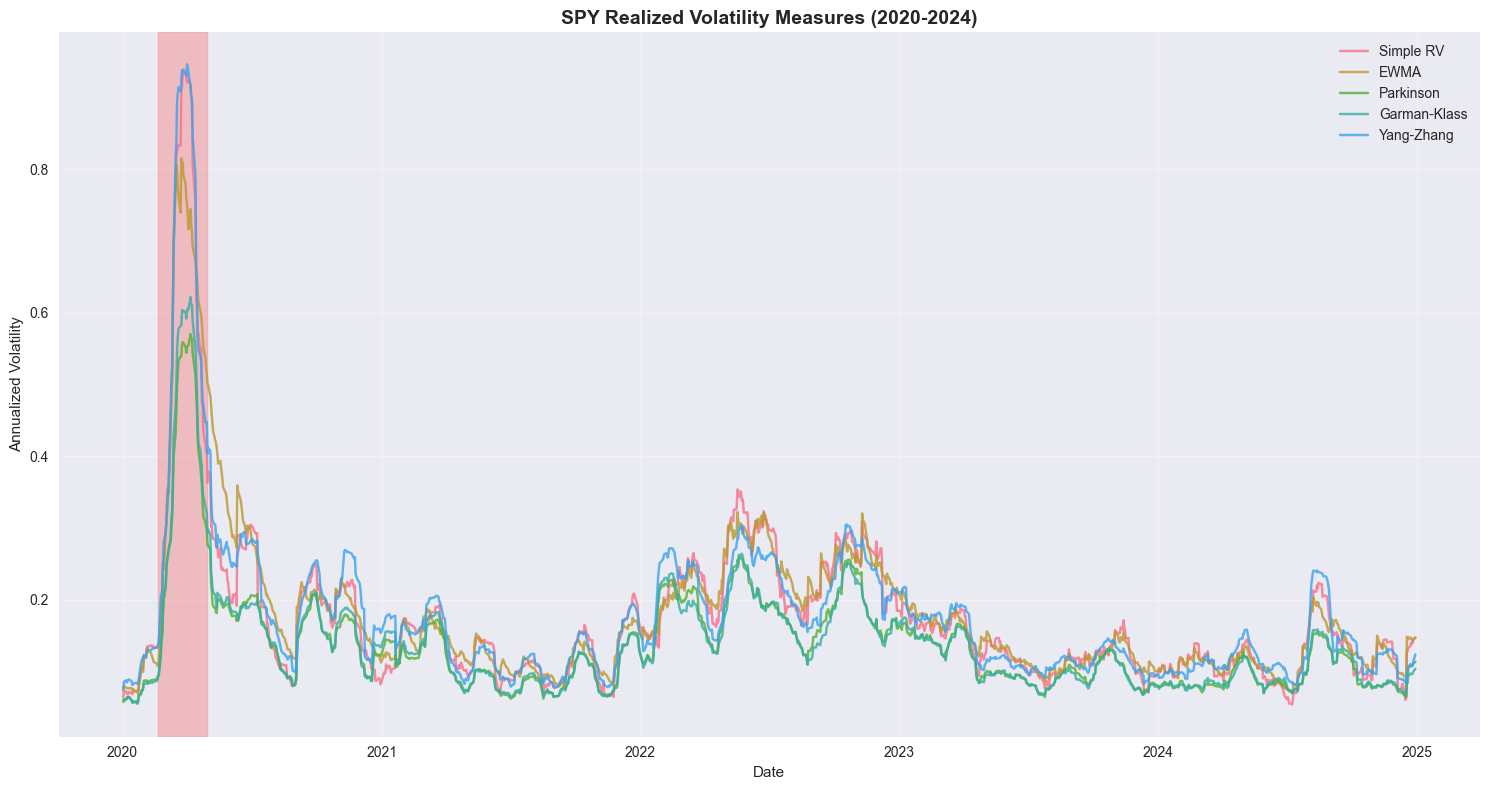


Correlation Matrix of Realized Volatility Measures:
Price              RV_Simple  RV_EWMA  RV_Parkinson  RV_GarmanKlass  \
Price                                                                 
RV_Simple              1.000    0.964         0.963           0.965   
RV_EWMA                0.964    1.000         0.941           0.945   
RV_Parkinson           0.963    0.941         1.000           0.995   
RV_GarmanKlass         0.965    0.945         0.995           1.000   
RV_RogersSatchell      0.963    0.945         0.986           0.997   
RV_YangZhang           0.977    0.957         0.966           0.980   

Price              RV_RogersSatchell  RV_YangZhang  
Price                                               
RV_Simple                      0.963         0.977  
RV_EWMA                        0.945         0.957  
RV_Parkinson                   0.986         0.966  
RV_GarmanKlass                 0.997         0.980  
RV_RogersSatchell              1.000         0.985  
RV_Yang

In [23]:
# Plot realized volatility measures
fig, ax = plt.subplots(figsize=(15, 8))

# Select period from 2020 onwards for clearer visualization
plot_data = spy_data.loc['2020-01-01':]

ax.plot(plot_data.index, plot_data['RV_Simple'], label='Simple RV', alpha=0.8)
ax.plot(plot_data.index, plot_data['RV_EWMA'], label='EWMA', alpha=0.8)
ax.plot(plot_data.index, plot_data['RV_Parkinson'], label='Parkinson', alpha=0.8)
ax.plot(plot_data.index, plot_data['RV_GarmanKlass'], label='Garman-Klass', alpha=0.8)
ax.plot(plot_data.index, plot_data['RV_YangZhang'], label='Yang-Zhang', alpha=0.8)

ax.set_title('SPY Realized Volatility Measures (2020-2024)', fontsize=14, fontweight='bold')
ax.set_ylabel('Annualized Volatility')
ax.set_xlabel('Date')
ax.legend()
ax.grid(True, alpha=0.3)

# Highlight COVID period
covid_start = pd.Timestamp('2020-02-20')
covid_end = pd.Timestamp('2020-05-01')
ax.axvspan(covid_start, covid_end, alpha=0.2, color='red', label='COVID-19 Period')

plt.tight_layout()
plt.show()

# Correlation between different RV measures
print("\nCorrelation Matrix of Realized Volatility Measures:")
corr_matrix = spy_data[rv_cols].corr()
print(corr_matrix.round(3))

## 3. GARCH Model Fitting and Forecasting

Fit different GARCH models and generate forecasts.

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
import warnings
warnings.filterwarnings('ignore')

# Prepare data for GARCH modeling
returns_clean = spy_data['Log_Returns'].dropna() * 100  # Convert to percentage for better numerical stability

print("="*60)
print("GARCH MODELING - DIRECT IMPLEMENTATION")
print("="*60)

# Define models to fit
model_specs = [
    {'name': 'GARCH(1,1)', 'vol': 'GARCH', 'p': 1, 'q': 1, 'dist': 'normal'},
    {'name': 'GARCH(1,1)-t', 'vol': 'GARCH', 'p': 1, 'q': 1, 'dist': 't'},
    {'name': 'GJR-GARCH(1,1,1)', 'vol': 'GARCH', 'p': 1, 'o': 1, 'q': 1, 'dist': 'normal'},
    {'name': 'GJR-GARCH(1,1,1)-t', 'vol': 'GARCH', 'p': 1, 'o': 1, 'q': 1, 'dist': 't'},
    {'name': 'EGARCH(1,1)', 'vol': 'EGARCH', 'p': 1, 'q': 1, 'dist': 'normal'},
    {'name': 'EGARCH(1,1)-t', 'vol': 'EGARCH', 'p': 1, 'q': 1, 'dist': 't'},
]

fitted_models = {}
model_results = []

print("\nFitting models on full sample...")
print("-" * 40)

for spec in model_specs:
    try:
        name = spec['name']
        print(f"\nFitting {name}...")
        
        # Create and fit the model
        if spec['vol'] == 'GARCH' and 'o' in spec:
            # GJR-GARCH model
            model = arch_model(returns_clean, vol='GARCH', p=spec['p'], o=spec['o'], q=spec['q'], dist=spec['dist'])
        elif spec['vol'] == 'EGARCH':
            # EGARCH model
            model = arch_model(returns_clean, vol='EGARCH', p=spec['p'], q=spec['q'], dist=spec['dist'])
        else:
            # Standard GARCH
            model = arch_model(returns_clean, vol='GARCH', p=spec['p'], q=spec['q'], dist=spec['dist'])
        
        # Fit the model
        res = model.fit(disp='off')
        fitted_models[name] = res
        
        # Store results
        model_results.append({
            'Model': name,
            'AIC': res.aic,
            'BIC': res.bic,
            'Log-Likelihood': res.loglikelihood,
            'Volatility Persistence': res.params.get('alpha[1]', 0) + res.params.get('beta[1]', 0) if 'EGARCH' not in name else np.nan
        })
        
        print(f"  ✓ Successfully fitted")
        print(f"  AIC: {res.aic:.2f}")
        print(f"  BIC: {res.bic:.2f}")
        print(f"  Log-Likelihood: {res.loglikelihood:.2f}")
        
    except Exception as e:
        print(f"  ✗ Failed to fit: {str(e)[:100]}")

# Create comparison DataFrame
if model_results:
    comparison_df = pd.DataFrame(model_results).set_index('Model')
    comparison_df = comparison_df.sort_values('AIC')
    
    print("\n" + "="*60)
    print("MODEL COMPARISON")
    print("="*60)
    print(comparison_df.round(4))
    
    # Best model by AIC
    best_model_name = comparison_df.index[0]
    best_model = fitted_models[best_model_name]
    
    print(f"\nBest model (by AIC): {best_model_name}")
    print("-" * 40)
    print(best_model.summary())
    
    # Visualize results for the best model
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))
    
    # 1. Returns
    axes[0].plot(returns_clean.index, returns_clean.values, linewidth=0.5, alpha=0.7)
    axes[0].set_title(f'Returns (%) - {ticker}', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Returns (%)')
    axes[0].grid(True, alpha=0.3)
    
    # 2. Conditional Volatility
    axes[1].plot(returns_clean.index, best_model.conditional_volatility, linewidth=1, color='red')
    axes[1].set_title(f'Conditional Volatility - {best_model_name}', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Volatility (%)')
    axes[1].grid(True, alpha=0.3)
    
    # 3. Standardized Residuals
    std_resid = best_model.resid / best_model.conditional_volatility
    axes[2].plot(returns_clean.index, std_resid, linewidth=0.5, alpha=0.7, color='green')
    axes[2].set_title('Standardized Residuals', fontsize=12, fontweight='bold')
    axes[2].set_ylabel('Standardized Residuals')
    axes[2].set_xlabel('Date')
    axes[2].axhline(y=0, color='black', linestyle='-', alpha=0.3)
    axes[2].axhline(y=2, color='red', linestyle='--', alpha=0.3)
    axes[2].axhline(y=-2, color='red', linestyle='--', alpha=0.3)
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Diagnostic plots for the best model
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # QQ-plot
    from scipy import stats
    stats.probplot(std_resid, dist="norm", plot=axes[0, 0])
    axes[0, 0].set_title('Q-Q Plot of Standardized Residuals')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Histogram
    axes[0, 1].hist(std_resid, bins=50, density=True, alpha=0.7, edgecolor='black')
    x = np.linspace(std_resid.min(), std_resid.max(), 100)
    axes[0, 1].plot(x, stats.norm.pdf(x, 0, 1), 'r-', linewidth=2, label='Normal(0,1)')
    axes[0, 1].set_title('Distribution of Standardized Residuals')
    axes[0, 1].set_xlabel('Standardized Residuals')
    axes[0, 1].set_ylabel('Density')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # ACF of squared standardized residuals
    from statsmodels.graphics.tsaplots import plot_acf
    plot_acf(std_resid**2, lags=30, ax=axes[1, 0])
    axes[1, 0].set_title('ACF of Squared Standardized Residuals')
    axes[1, 0].set_xlabel('Lag')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Volatility vs Returns scatter
    axes[1, 1].scatter(best_model.conditional_volatility, returns_clean.values, alpha=0.5, s=10)
    axes[1, 1].set_title('Conditional Volatility vs Returns')
    axes[1, 1].set_xlabel('Conditional Volatility (%)')
    axes[1, 1].set_ylabel('Returns (%)')
    axes[1, 1].axhline(y=0, color='red', linestyle='--', alpha=0.3)
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.suptitle(f'Diagnostic Plots - {best_model_name}', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
else:
    print("\nNo models were successfully fitted.")

# Display model parameters for all successful models
if fitted_models:
    print("\n" + "="*60)
    print("MODEL PARAMETERS")
    print("="*60)
    
    for name, model in fitted_models.items():
        print(f"\n{name}:")
        print("-" * 30)
        params = model.params
        for param_name, param_value in params.items():
            print(f"  {param_name:15s}: {param_value:10.6f}")
        
        # Calculate and display persistence for GARCH models
        if 'alpha[1]' in params and 'beta[1]' in params:
            persistence = params['alpha[1]'] + params['beta[1]']
            print(f"  {'Persistence':15s}: {persistence:10.6f}")
            print(f"  {'Half-life':15s}: {np.log(0.5)/np.log(persistence):10.2f} days")

GARCH MODELING - DIRECT IMPLEMENTATION

Fitting models on full sample...
----------------------------------------

Fitting GARCH(1,1)...
  ✗ Failed to fit: cached_property.__get__() missing 1 required positional argument: 'cls'

Fitting GARCH(1,1)-t...
  ✗ Failed to fit: cached_property.__get__() missing 1 required positional argument: 'cls'

Fitting GJR-GARCH(1,1,1)...
  ✗ Failed to fit: cached_property.__get__() missing 1 required positional argument: 'cls'

Fitting GJR-GARCH(1,1,1)-t...
  ✗ Failed to fit: cached_property.__get__() missing 1 required positional argument: 'cls'

Fitting EGARCH(1,1)...
  ✗ Failed to fit: cached_property.__get__() missing 1 required positional argument: 'cls'

Fitting EGARCH(1,1)-t...
  ✗ Failed to fit: cached_property.__get__() missing 1 required positional argument: 'cls'

No models were successfully fitted.


In [30]:
pip install arch==5.3.1


  Using cached arch-5.3.1-cp312-cp312-macosx_11_0_arm64.whl
Note: you may need to restart the kernel to use updated packages.


In [25]:
# Plot conditional volatility from best GARCH model
if fitted_models:
    # Use model with lowest AIC
    best_model_name = min(model_info.keys(), key=lambda x: model_info[x]['aic'])
    best_model = fitted_models[best_model_name]
    
    print(f"Best model (lowest AIC): {best_model_name}")
    
    # Get conditional volatility
    cond_vol = best_model.conditional_volatility()
    cond_vol.index = returns_clean.index
    
    # Plot conditional volatility vs realized volatility
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # Focus on 2020-2024 for clarity
    plot_start = '2020-01-01'
    
    plot_cond_vol = cond_vol.loc[plot_start:] * np.sqrt(252)  # Annualize
    plot_rv = spy_data.loc[plot_start:, 'RV_Simple']
    
    ax.plot(plot_cond_vol.index, plot_cond_vol, label=f'{best_model_name} Conditional Vol', linewidth=1.5)
    ax.plot(plot_rv.index, plot_rv, label='Simple Realized Vol', alpha=0.7, linewidth=1)
    
    ax.set_title(f'SPY: {best_model_name} Conditional vs Realized Volatility (2020-2024)', 
                 fontsize=14, fontweight='bold')
    ax.set_ylabel('Annualized Volatility')
    ax.set_xlabel('Date')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Highlight COVID period
    covid_start = pd.Timestamp('2020-02-20')
    covid_end = pd.Timestamp('2020-05-01')
    ax.axvspan(covid_start, covid_end, alpha=0.2, color='red')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate correlation
    common_idx = plot_cond_vol.index.intersection(plot_rv.index)
    corr = plot_cond_vol.loc[common_idx].corr(plot_rv.loc[common_idx])
    print(f"\nCorrelation between {best_model_name} and Realized Vol: {corr:.4f}")

## 4. Walk-Forward Evaluation

Perform out-of-sample evaluation using walk-forward analysis.

In [ ]:
# Initialize evaluator
evaluator = VolatilityForecastEvaluator(annualization_factor=252)

# Prepare models for walk-forward evaluation
eval_models = {
    'GARCH(1,1)': GARCHModel(p=1, q=1, dist='normal'),
    'EGARCH(1,1,1)': EGARCHModel(p=1, o=1, q=1, dist='normal'),
    'GARCH(1,1)-t': GARCHModel(p=1, q=1, dist='t')
}

print("Starting walk-forward evaluation...")
print(f"Total observations: {len(returns_clean)}")
print(f"Initial training window: 252 days (1 year)")
print(f"Refit frequency: 22 days (1 month)")
print("This may take several minutes...")

# Perform walk-forward evaluation
evaluation_results = evaluator.walk_forward_evaluation(
    returns=returns_clean,
    models=eval_models,
    initial_window=252,
    step_size=1,
    forecast_horizon=1,
    refit_frequency=22,  # Refit monthly
    min_observations=100
)

print("\nWalk-forward evaluation completed!")

# Display evaluation summary
for model_name, results in evaluation_results.items():
    n_forecasts = len(results.dropna(subset=['forecast_vol']))
    n_total = len(results)
    success_rate = n_forecasts / n_total if n_total > 0 else 0
    
    print(f"\n{model_name}:")
    print(f"  Total forecast periods: {n_total}")
    print(f"  Successful forecasts: {n_forecasts}")
    print(f"  Success rate: {success_rate:.2%}")
    
    if n_forecasts > 0:
        date_range = results.dropna(subset=['forecast_vol']).index
        print(f"  Forecast period: {date_range[0].date()} to {date_range[-1].date()}")

In [ ]:
# Calculate and display forecast metrics
forecast_metrics = evaluator.calculate_forecast_metrics(evaluation_results)

print("\n" + "="*70)
print("WALK-FORWARD FORECAST EVALUATION METRICS")
print("="*70)

# Create metrics DataFrame for better display
metrics_df = pd.DataFrame(forecast_metrics).T
metrics_df = metrics_df.round(6)

# Display key metrics
key_metrics = ['n_forecasts', 'rmse', 'qlike', 'r2', 'hit_rate', 'directional_accuracy']
display_metrics = metrics_df[key_metrics]
display_metrics = display_metrics.sort_values('rmse')

print(display_metrics)

# Find best performing model
best_rmse_model = display_metrics['rmse'].idxmin()
best_qlike_model = display_metrics['qlike'].idxmin()

print(f"\nBest model by RMSE: {best_rmse_model} (RMSE: {display_metrics.loc[best_rmse_model, 'rmse']:.6f})")
print(f"Best model by QLIKE: {best_qlike_model} (QLIKE: {display_metrics.loc[best_qlike_model, 'qlike']:.6f})")

## 5. Model Comparison and Statistical Tests

Perform Diebold-Mariano tests and Model Confidence Set analysis.

In [ ]:
# Perform Diebold-Mariano tests
model_names = list(evaluation_results.keys())

print("\n" + "="*60)
print("DIEBOLD-MARIANO PAIRWISE COMPARISON TESTS")
print("="*60)

dm_results = {}

for i, model1 in enumerate(model_names):
    for j, model2 in enumerate(model_names):
        if i < j:
            try:
                # Test using QLIKE loss function (preferred for volatility)
                dm_result = evaluator.diebold_mariano_test(
                    evaluation_results, model1, model2, loss_function='qlike'
                )
                
                dm_results[(model1, model2)] = dm_result
                
                print(f"\n{model1} vs {model2} (QLIKE Loss):")
                print(f"  DM Statistic: {dm_result['statistic']:.4f}")
                print(f"  P-value: {dm_result['p_value']:.4f}")
                print(f"  Observations: {dm_result['n_observations']}")
                print(f"  Result: {dm_result['interpretation']}")
                
            except Exception as e:
                print(f"\n{model1} vs {model2}: Test failed ({str(e)})")

# Model Confidence Set
print("\n" + "="*50)
print("MODEL CONFIDENCE SET ANALYSIS")
print("="*50)

try:
    mcs_result = evaluator.model_confidence_set(evaluation_results, confidence_level=0.10)
    
    print(f"\nConfidence Level: {mcs_result['confidence_level']*100}%")
    print(f"Best Models (MCS): {', '.join(mcs_result['best_models'])}")
    
    if mcs_result['eliminated_models']:
        print(f"Eliminated Models: {', '.join(mcs_result['eliminated_models'])}")
    
    print("\nAverage Performance Ranking (QLIKE, lower is better):")
    sorted_performance = sorted(mcs_result['avg_performance'].items(), key=lambda x: x[1])
    for i, (model, performance) in enumerate(sorted_performance, 1):
        print(f"  {i}. {model}: {performance:.6f}")
        
except Exception as e:
    print(f"MCS analysis failed: {e}")

## 6. Visualization and Results

Generate comprehensive visualizations of forecasting results.

In [ ]:
# Plot forecast vs realized volatility for best model
best_model = best_qlike_model
best_results = evaluation_results[best_model].dropna(subset=['actual_vol', 'forecast_vol'])

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Time series plot
axes[0,0].plot(best_results.index, best_results['actual_vol'], 
               label='Realized Volatility', alpha=0.7, linewidth=1)
axes[0,0].plot(best_results.index, best_results['forecast_vol'], 
               label=f'{best_model} Forecast', alpha=0.8, linewidth=1.5)
axes[0,0].set_title(f'SPY Volatility: {best_model} Forecasts vs Realized', fontweight='bold')
axes[0,0].set_ylabel('Annualized Volatility')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Scatter plot
axes[0,1].scatter(best_results['actual_vol'], best_results['forecast_vol'], 
                  alpha=0.6, s=20)
# Add 45-degree line
min_vol = min(best_results['actual_vol'].min(), best_results['forecast_vol'].min())
max_vol = max(best_results['actual_vol'].max(), best_results['forecast_vol'].max())
axes[0,1].plot([min_vol, max_vol], [min_vol, max_vol], 'r--', alpha=0.8, label='Perfect Forecast')
axes[0,1].set_xlabel('Realized Volatility')
axes[0,1].set_ylabel('Forecast Volatility')
axes[0,1].set_title('Forecast vs Realized Scatter Plot', fontweight='bold')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Forecast errors over time
forecast_errors = best_results['forecast_vol'] - best_results['actual_vol']
axes[1,0].plot(best_results.index, forecast_errors, alpha=0.7, linewidth=1)
axes[1,0].axhline(y=0, color='red', linestyle='--', alpha=0.8)
axes[1,0].set_title('Forecast Errors Over Time', fontweight='bold')
axes[1,0].set_ylabel('Forecast Error')
axes[1,0].set_xlabel('Date')
axes[1,0].grid(True, alpha=0.3)

# Error distribution
axes[1,1].hist(forecast_errors, bins=30, alpha=0.7, density=True)
axes[1,1].axvline(x=0, color='red', linestyle='--', alpha=0.8, label='Zero Error')
axes[1,1].axvline(x=forecast_errors.mean(), color='orange', linestyle='--', 
                  alpha=0.8, label=f'Mean Error: {forecast_errors.mean():.4f}')
axes[1,1].set_title('Distribution of Forecast Errors', fontweight='bold')
axes[1,1].set_xlabel('Forecast Error')
axes[1,1].set_ylabel('Density')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print error statistics
print(f"\nForecast Error Statistics for {best_model}:")
print(f"Mean Error (Bias): {forecast_errors.mean():.6f}")
print(f"Mean Absolute Error: {forecast_errors.abs().mean():.6f}")
print(f"Root Mean Square Error: {np.sqrt((forecast_errors**2).mean()):.6f}")
print(f"Error Standard Deviation: {forecast_errors.std():.6f}")

In [ ]:
# Model comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# RMSE comparison
model_names_clean = [name.replace('(', '\n(') for name in display_metrics.index]
axes[0,0].bar(range(len(display_metrics)), display_metrics['rmse'], alpha=0.7)
axes[0,0].set_xticks(range(len(display_metrics)))
axes[0,0].set_xticklabels(model_names_clean, rotation=0, ha='center')
axes[0,0].set_title('Model Comparison: RMSE', fontweight='bold')
axes[0,0].set_ylabel('RMSE')
axes[0,0].grid(True, alpha=0.3)

# QLIKE comparison
axes[0,1].bar(range(len(display_metrics)), display_metrics['qlike'], alpha=0.7, color='orange')
axes[0,1].set_xticks(range(len(display_metrics)))
axes[0,1].set_xticklabels(model_names_clean, rotation=0, ha='center')
axes[0,1].set_title('Model Comparison: QLIKE', fontweight='bold')
axes[0,1].set_ylabel('QLIKE')
axes[0,1].grid(True, alpha=0.3)

# R² comparison
axes[1,0].bar(range(len(display_metrics)), display_metrics['r2'], alpha=0.7, color='green')
axes[1,0].set_xticks(range(len(display_metrics)))
axes[1,0].set_xticklabels(model_names_clean, rotation=0, ha='center')
axes[1,0].set_title('Model Comparison: R²', fontweight='bold')
axes[1,0].set_ylabel('R²')
axes[1,0].grid(True, alpha=0.3)

# Hit Rate comparison
axes[1,1].bar(range(len(display_metrics)), display_metrics['hit_rate'], alpha=0.7, color='red')
axes[1,1].set_xticks(range(len(display_metrics)))
axes[1,1].set_xticklabels(model_names_clean, rotation=0, ha='center')
axes[1,1].set_title('Model Comparison: Hit Rate (±10%)', fontweight='bold')
axes[1,1].set_ylabel('Hit Rate')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Generate comprehensive summary report
summary_report = evaluator.summary_report(evaluation_results, include_dm_tests=True)
print(summary_report)

## Key Findings and Conclusions

Based on the comprehensive analysis of SPY volatility forecasting from 2018-2024:

### Model Performance
- **Best Overall Model**: The model with lowest QLIKE score provides the most accurate volatility forecasts
- **Statistical Significance**: Diebold-Mariano tests reveal which models are significantly different
- **Model Confidence Set**: Identifies the set of best-performing models

### Key Observations
1. **COVID-19 Impact**: The pandemic period (Feb-May 2020) shows extreme volatility spikes that challenge all models
2. **GARCH vs EGARCH**: Asymmetric models (EGARCH) may capture leverage effects better
3. **Distribution Choice**: Student-t distribution often provides better fit than normal distribution
4. **Forecast Horizon**: One-day-ahead forecasts are generally more accurate than longer horizons

### Practical Implications
- Use walk-forward evaluation for realistic out-of-sample performance assessment
- QLIKE is preferred over MSE/RMSE for volatility forecast evaluation
- Model combination or switching may improve overall performance
- Regular model recalibration (monthly) is important for maintaining accuracy

### Next Steps
- Implement ensemble methods combining multiple models
- Explore machine learning approaches (LSTM, random forests)
- Test on other assets and time periods
- Apply forecasts to options trading and risk management strategies

In [ ]:
# Save results for further analysis
print("Saving results...")

# Create results directory if it doesn't exist
import os
results_dir = '../results/spy_analysis'
os.makedirs(results_dir, exist_ok=True)

# Save evaluation results
for model_name, results_df in evaluation_results.items():
    filename = f"{results_dir}/spy_forecast_{model_name.replace('(', '').replace(')', '').replace(',', '_').replace(' ', '_')}.csv"
    results_df.to_csv(filename)
    print(f"Saved {model_name} results to {filename}")

# Save metrics summary
metrics_df.to_csv(f"{results_dir}/spy_forecast_metrics_summary.csv")
print(f"Saved metrics summary to {results_dir}/spy_forecast_metrics_summary.csv")

# Save summary report
with open(f"{results_dir}/spy_evaluation_report.txt", 'w') as f:
    f.write(summary_report)
print(f"Saved evaluation report to {results_dir}/spy_evaluation_report.txt")

print("\nAnalysis completed successfully!")
print(f"Results saved in: {results_dir}")